In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.utils import preprocessing as pp

In [144]:
def load_data(data_path, dt = 1e-1, t_washout_len = 4, t_train_len = 128, t_val_len = 64, grid_upsample = 4, train_var = "gal"):
   # load rijke system from data
   data_dict = pp.read_h5(data_path)

   t_transient_len = data_dict["t_transient"]

   data_dt = data_dict["t"][1]-data_dict["t"][0]
   upsample = int(np.round(dt/data_dt))

   pres = data_dict["P"][:,1:-1:grid_upsample]
   pres_single = data_dict["P"][:,5][:,None]
   vel = data_dict["U"][:,1:-1:grid_upsample]
   pres_vel = np.hstack((data_dict["P"][:,1:-1],data_dict["U"]))

   eta = data_dict["y"][:, 0 : data_dict["N_g"]]  # Galerkin variables velocity
   mu = data_dict["y"][:, data_dict["N_g"] : 2 * data_dict["N_g"]]  # Galerkin variables pressure
   gal = data_dict["y"][:, 0 : 2 * data_dict["N_g"]]
   
   if train_var == "gal":
    U_sim = gal
   elif train_var == "pres":
    U_sim =  pres
   elif train_var == "vel":
    U_sim = vel
   elif train_var == "pres_vel":
    U_sim = pres_vel

   t_sim = data_dict["t"]

   # upsample
   U = U_sim[::upsample,:]
   t = t_sim[::upsample]

   # cut the transient    
   N_transient = int(np.round(t_transient_len/dt))
   U = U[N_transient:,:]
   t = t[N_transient:]-t[N_transient]

   # separate into washout, train, val
   N_washout = int(np.round(t_washout_len/dt))
   N_train = int(np.round(t_train_len/dt))
   N_val = int(np.round(t_val_len/dt))

   U_washout_train = U[0:N_washout,:]

   U_train = U[N_washout:N_washout+N_train-1,:]
   Y_train = U[N_washout+1:N_washout+N_train,:]
   t_train = t[N_washout+1:N_washout+N_train]

   U_washout_val = U[N_washout+N_train:2*N_washout+N_train,:]
   U_val = U[2*N_washout+N_train:2*N_washout+N_train+N_val-1,:]
   Y_val = U[2*N_washout+N_train+1:2*N_washout+N_train+N_val,:]
   t_val = t[2*N_washout+N_train+1:2*N_washout+N_train+N_val]

   U_data = U[:N_washout+N_train]
   return U_washout_train, U_train, Y_train, t_train, U_washout_val, U_val, Y_val, t_val, U_data

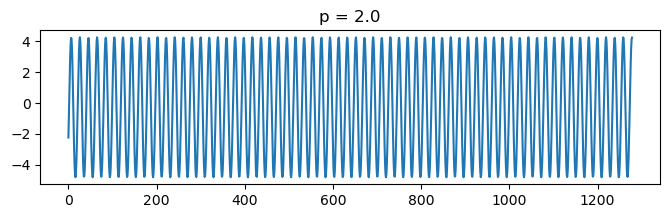

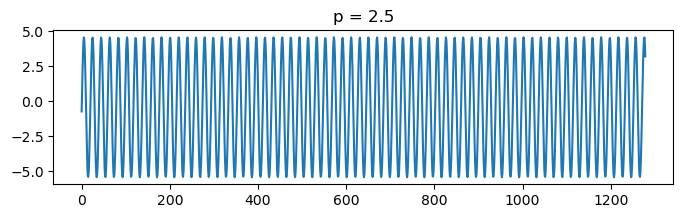

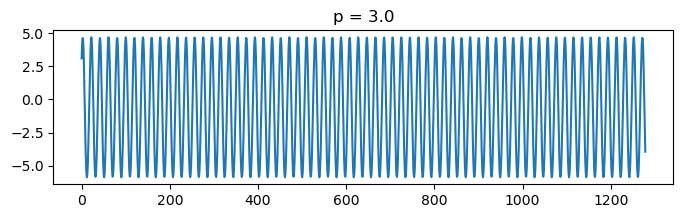

In [145]:
p_list = [2.0,2.5,3.0]
p_name_list = ["2","2_5","3"]
len_p_list = len(p_list)
U_washout_train = [None]*len_p_list
U_train = [None]*len_p_list
U_data = [None]*len_p_list
Y_train = [None]*len_p_list
t_train = [None]*len_p_list
U_washout_val = [None]*len_p_list
U_val = [None]*len_p_list
U_val = [None]*len_p_list
Y_val = [None]*len_p_list
t_val = [None]*len_p_list

P_washout_train = [None]*len_p_list
P_train = [None]*len_p_list
P_washout_val = [None]*len_p_list
P_val = [None]*len_p_list
P_mean = np.array(np.mean(p_list))

for p_idx in range(len_p_list):
    train_str = f"data/rijke_kings_beta_{p_name_list[p_idx]}_tau_0_2_long_fine.h5"
    U_washout_train[p_idx], U_train[p_idx], Y_train[p_idx], t_train[p_idx], U_washout_val[p_idx], U_val[p_idx], Y_val[p_idx], t_val[p_idx], U_data[p_idx] = load_data(train_str)
    P_washout_train[p_idx] = p_list[p_idx]*np.ones((len(U_washout_train[p_idx]),1))
    P_train[p_idx] = p_list[p_idx]*np.ones((len(U_train[p_idx]),1))
    P_washout_val[p_idx] = p_list[p_idx]*np.ones((len(U_washout_val[p_idx]),1))
    P_val[p_idx] = p_list[p_idx]*np.ones((len(U_val[p_idx]),1))

U_data = np.vstack(U_data)

for p_idx in range(len_p_list):
    plt.figure(figsize = (8,2))
    plt.plot(U_train[p_idx][:,0])
    plt.title(f"p = {p_list[p_idx]}")

U_mean = U_data.mean(axis = 0)
U_std = U_data.std(axis = 0)
m = U_data.min(axis=0)
M = U_data.max(axis=0)
U_norm = M-m 
scale = (U_mean, U_std)

input_bias = np.array([np.mean(np.abs((U_data-scale[0])/scale[1]))])

dim = U_train[0].shape[1]

In [146]:
my_ESN = ESN(reservoir_size = 1200, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = 5.1, spectral_radius = 1.0,
                leak_factor = 1.0, input_bias = input_bias, input_normalization = scale, parameter_normalization=[np.array([6.0]),np.array([4.9])])

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [147]:
my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train)

In [137]:
def L2_error(y, y_pred):
    return np.linalg.norm(y-y_pred, 'fro')

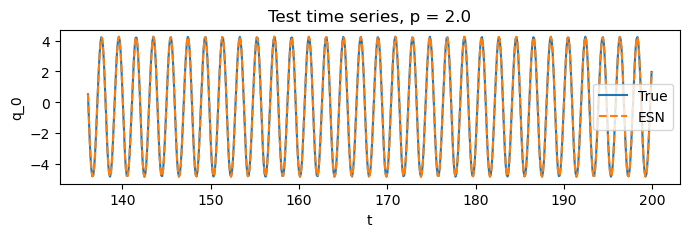

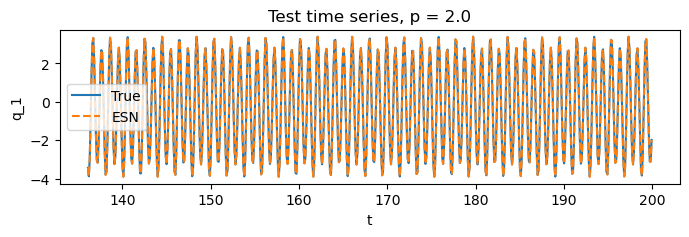

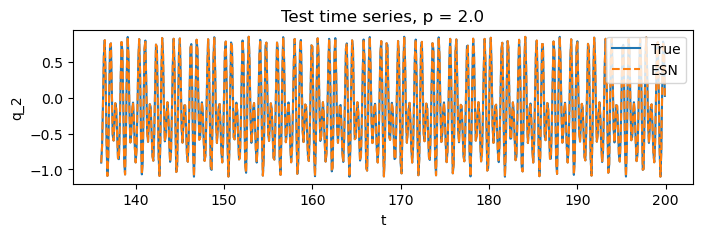

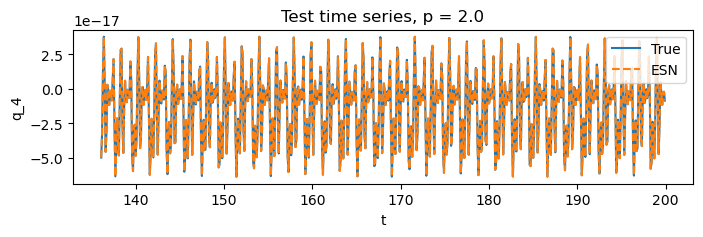

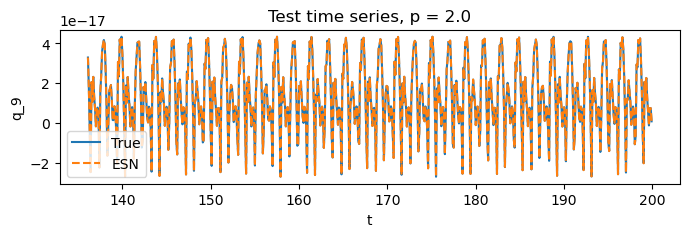

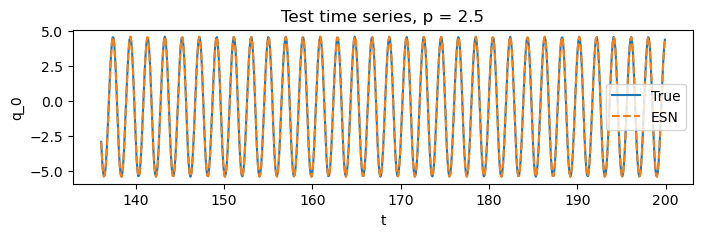

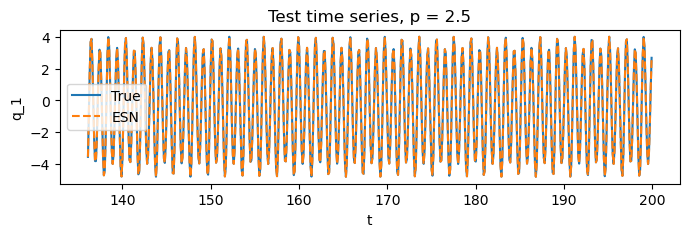

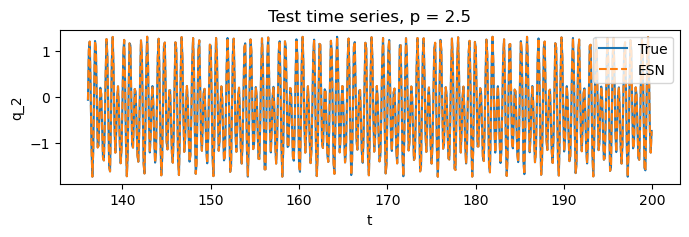

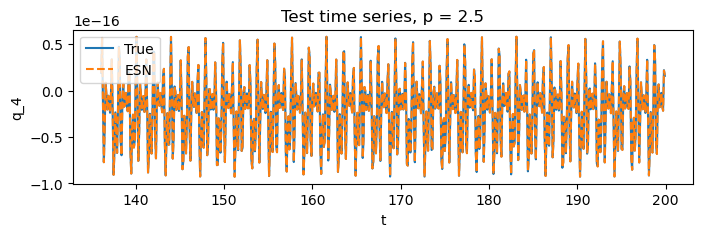

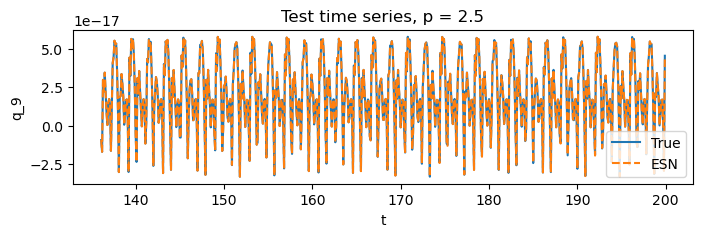

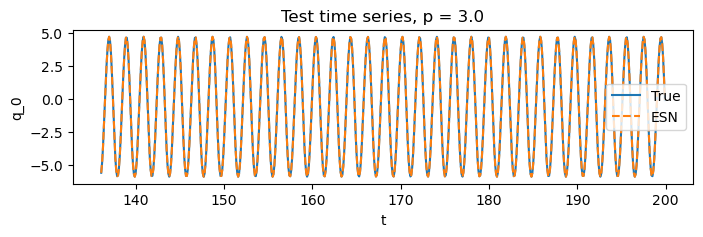

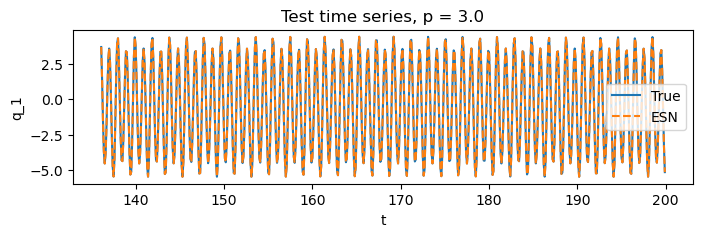

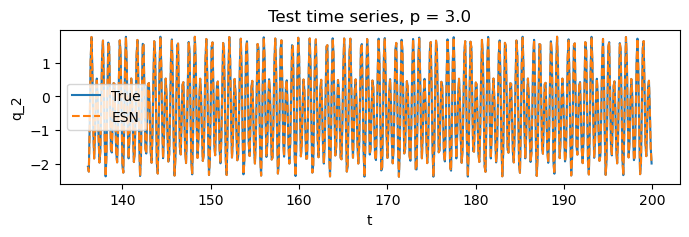

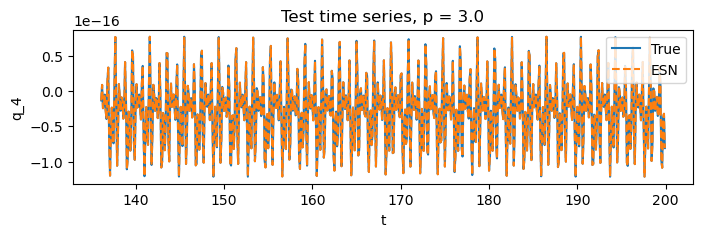

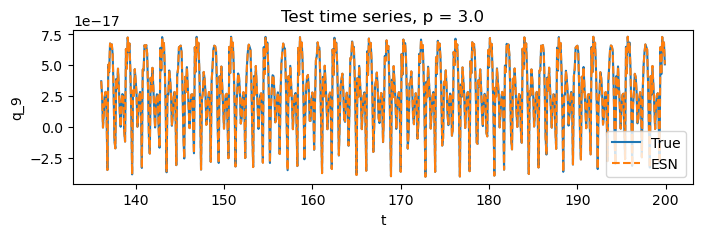

Train error:  0.31831568325360415
Validation error:  0.12062232877008268
Train error:  0.36740263269337425
Validation error:  0.4432721250154314
Train error:  0.2410046364953393
Validation error:  0.23730306129538492


In [171]:
plt_idx = [0,1,2,4,9]
Y_pred_train = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_train_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[p_idx], N_t = len(U_train[p_idx]), P_washout=P_washout_train[p_idx], P = P_train[p_idx])
    Y_pred_train[p_idx] = Y_pred_train_[1:,:]
#    for j in plt_idx:
#        plt.figure(figsize=(8,2))
#        plt.plot(t_train[p_idx], Y_train[p_idx][:,j])
#        plt.plot(t_train[p_idx], Y_pred_train[p_idx][:,j],'--')
#        plt.title(f"Training time series, p = {p_list[p_idx]}")
#        plt.xlabel("t")
#        plt.ylabel(f"q_{j}")
#        plt.legend(["True", "ESN"])

Y_pred_val = [None]*len_p_list
for p_idx in range(len_p_list):
    _, Y_pred_val_ = my_ESN.closed_loop_with_washout(U_washout = U_washout_val[p_idx], N_t = len(U_val[p_idx]), P_washout=P_washout_val[p_idx], P = P_val[p_idx])
    Y_pred_val[p_idx] = Y_pred_val_[1:,:]
    for j in plt_idx:
        plt.figure(figsize=(8,2))
        #plt.plot(t_val, Y_val[:,j]-Y_pred_val[:,j])
        plt.plot(t_val[p_idx][:], Y_val[p_idx][:,j])
        plt.plot(t_val[p_idx][:], Y_pred_val[p_idx][:,j],'--')
        plt.title(f"Test time series, p = {p_list[p_idx]}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])
plt.show()

# calculate error
for p_idx in range(len_p_list):
    train_error = L2_error(Y_train[p_idx], Y_pred_train[p_idx])
    val_error = L2_error(Y_val[p_idx], Y_pred_val[p_idx])
    print("Train error: ", train_error)
    print("Validation error: ", val_error)

Train error:  244.82637802220884
Validation error:  70.11928889718475
Train error:  175.47253986312637
Validation error:  71.13060576156902
Train error:  383.80900826049975
Validation error:  273.45120886496613


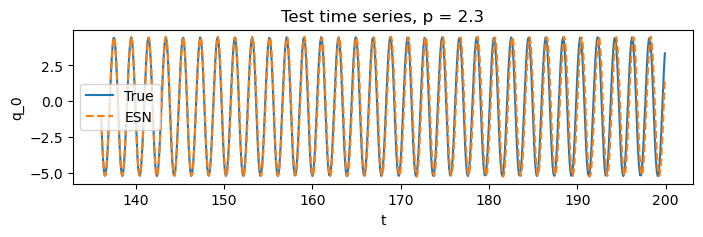

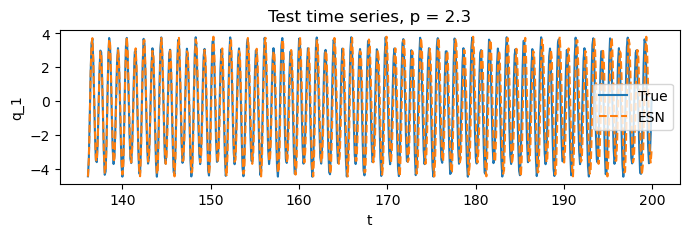

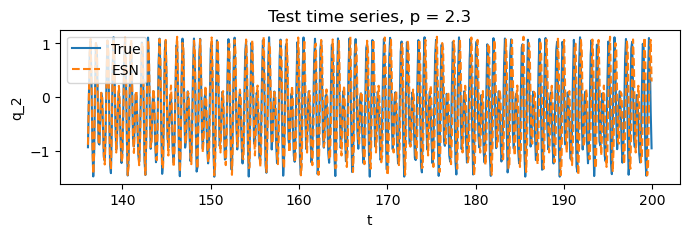

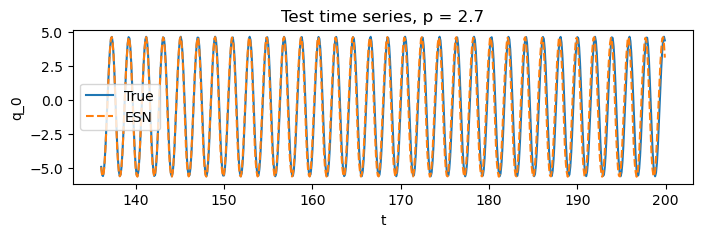

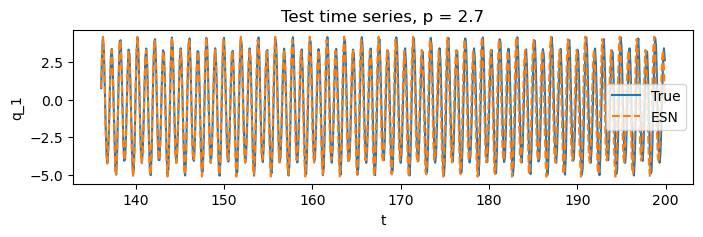

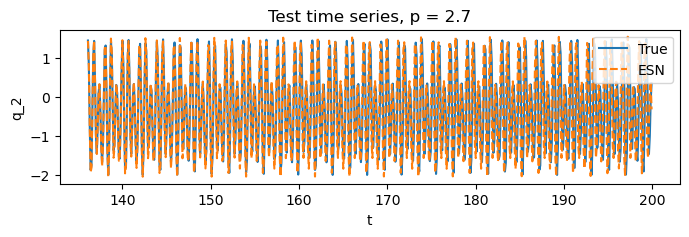

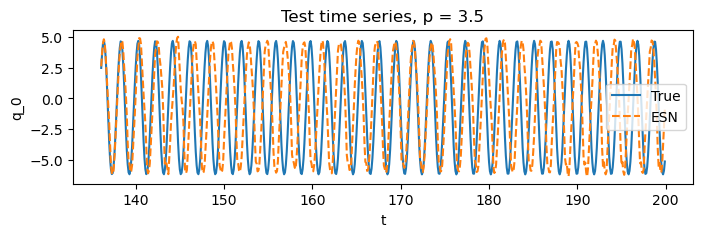

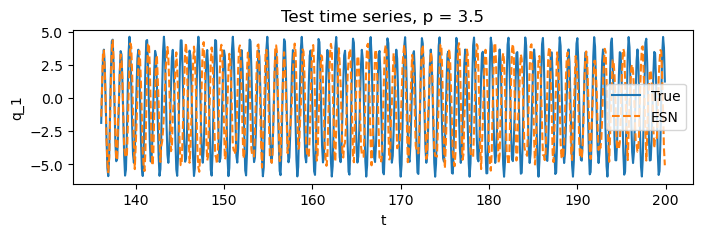

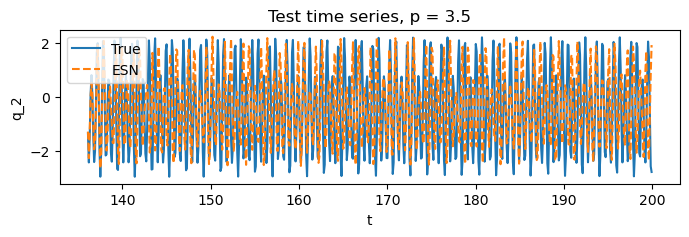

In [149]:
pp_test_list = [2.3,2.7,3.5]
pp_test_name_list = ["2_3","2_7","3_5"]
for test_idx, pp_test in enumerate(pp_test_list): 
    test_str = f"data/rijke_kings_beta_{pp_test_name_list[test_idx]}_tau_0_2_long_fine.h5"
    U_washout_test, U_test, Y_test, t_test, U_washout_testval, U_testval, Y_testval, t_testval, U_data_test = load_data(test_str)
    P_test = pp_test*np.ones((len(U_test),1))
    P_testval = pp_test*np.ones((len(U_testval),1))
    P_washout_test = pp_test*np.ones((len(U_washout_test),1))
    P_washout_testval = pp_test*np.ones((len(U_washout_testval),1))
    X_pred_test, Y_pred_test = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = len(U_test), P_washout=P_washout_test, P = P_test)
    Y_pred_test = Y_pred_test[1:,:]

    X_pred_testval, Y_pred_testval = my_ESN.closed_loop_with_washout(U_washout = U_washout_testval, N_t = len(U_testval), P_washout=P_washout_testval, P = P_testval)
    Y_pred_testval = Y_pred_testval[1:,:]
    for j in plt_idx:
        plt.figure(figsize=(8,2))
        #plt.plot(t_test, Y_test[:,j])
        #plt.plot(t_test, Y_pred_test[:,j])
        plt.plot(t_testval[:], Y_testval[:,j])
        plt.plot(t_testval[:], Y_pred_testval[:,j],'--')
        plt.title(f"Test time series, p = {pp_test}")
        plt.xlabel("t")
        plt.ylabel(f"q_{j}")
        plt.legend(["True", "ESN"])

    test_error = L2_error(Y_test, Y_pred_test)
    testval_error = L2_error(Y_testval, Y_pred_testval)
    print("Train error: ", test_error)
    print("Validation error: ", testval_error)

In [164]:
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint

my_beta = 2.5
my_rijke = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_beta,x_f=0.2,tau=0.2,heat_law="kings",damping="modal")
# Initial conditions
rand = np.random.RandomState(seed=10)
y0 = np.zeros(my_rijke.N_dim + 2)
y0[0 : my_rijke.N_dim] = rand.rand(my_rijke.N_dim)

# Temporal grid
t_sim_len = 250
data_dt = 1e-3
t_sim = np.arange(0, t_sim_len+data_dt, data_dt)

# Solve ODE using odeint
y_sim = odeint(my_rijke.ode, y0, t_sim, tfirst=True)
U_sim = y_sim[:, 0 : 2 * my_rijke.N_g]

# cut the transient
t_transient_len = 200   
t_washout_len = 4 
N_transient = int(np.round(t_transient_len/data_dt))
N_washout_data = int(np.round(t_washout_len/data_dt))
y_sim = y_sim[N_transient:,:]
U_sim = U_sim[N_transient:,:]
t_sim = t_sim[N_transient:]-t_sim[N_transient]

y_bar = y_sim[N_washout_data:,:]
U_bar = U_sim[N_washout_data:,:]
t_bar = t_sim[N_washout_data:]-t_sim[N_washout_data]

# upsample
dt = 1e-1
upsample = int(np.round(dt/data_dt))
U = U_sim[::upsample,:]
t = t_sim[::upsample]

# separate into washout, train, val
N_washout = int(np.round(t_washout_len/dt))

U_washout = U[0:N_washout,:]

U_grad = U[N_washout:-1,:]
Y_grad = U[N_washout:,:]
t_grad = t[N_washout:]-t[N_washout]

P_washout = my_beta*np.ones((len(U_washout),1))
P_grad = my_beta*np.ones((len(U_grad),1))

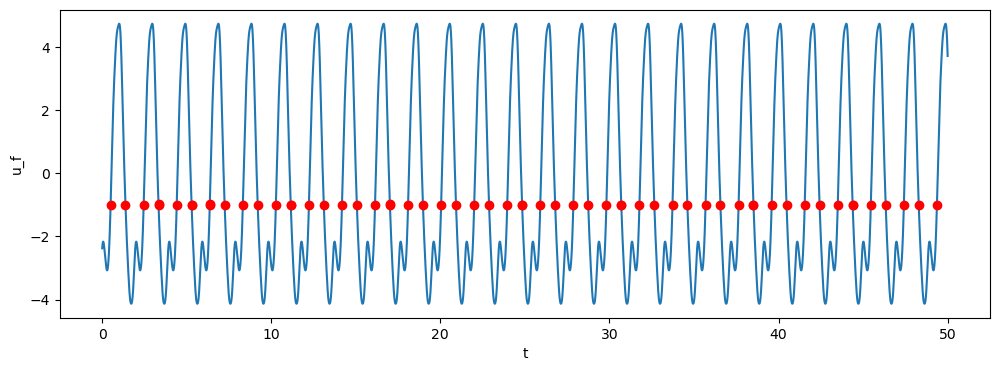

In [165]:
eta = y_sim[:, 0 : my_rijke.N_g]
u_f_sim = Rijke.toVelocity(my_rijke.N_g, eta, np.array([my_rijke.x_f]))
c_idx = np.where(np.abs(-1-u_f_sim) < 1e-2)[0]
plt.figure(figsize=(12,4))
plt.plot(t_sim,u_f_sim)
plt.plot(t_sim[c_idx],u_f_sim[c_idx],'ro')
plt.xlabel("t")
plt.ylabel("u_f")
plt.show()

In [166]:
# direct problem
dir0 = np.zeros(2*my_rijke.N_dim+2)
dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/data_dt,y_bar),tfirst= True)
dJ_dp_dir_true = 1/t_bar[-1]*dir[-1,-2]

# adjoint problem
adjT = np.zeros(my_rijke.N_dim+2)
adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args = (t_bar,1/data_dt,y_bar),tfirst= True)
dJ_dp_adj_true  = 1/t_bar[-1]*adj[-1,-2]

In [167]:
# Calculate numerically
# Find perturbed solutions (in beta)
h = 1e-5 # perturbation on the parameter

# left solution with beta = beta-h
my_rijke_beta_left = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_beta-h,x_f=0.2,tau=0.2,heat_law="kings",damping="modal")
y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
eta_bar_beta_left = y_bar_beta_left[:,0:my_rijke_beta_left.N_g] 
mu_bar_beta_left = y_bar_beta_left[:,my_rijke_beta_left.N_g:2*my_rijke_beta_left.N_g]
#J_beta_left = 1/t_bar[-1]*(y_bar_beta_left[-1,-1]-y_bar_beta_left[0,-1]) # time average until t
J_beta_left = 1/4*np.mean(np.sum(y_bar_beta_left[::upsample,0:2*my_rijke_beta_left.N_g]**2, axis = 1))
    
# right solution with beta = beta+h
my_rijke_beta_right = Rijke(N_g=10,N_c=10,c_1=0.1,c_2=0.06,beta=my_beta+h,x_f=0.2,tau=0.2,heat_law="kings",damping="modal")
y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
eta_bar_beta_right = y_bar_beta_right[:,0:my_rijke_beta_right.N_g] 
mu_bar_beta_right = y_bar_beta_right[:,my_rijke_beta_right.N_g:2*my_rijke_beta_right.N_g]
#J_beta_right = 1/t_bar[-1]*(y_bar_beta_right[-1,-1]-y_bar_beta_right[0,-1]) # time average until t
J_beta_right = 1/4*np.mean(np.sum(y_bar_beta_right[::upsample,0:2*my_rijke_beta_right.N_g]**2, axis = 1))

dJ_dp_num_true = (J_beta_right-J_beta_left)/(2*h) 

In [168]:
print(dJ_dp_dir_true)
print(dJ_dp_adj_true)
print(dJ_dp_num_true)

0.0
0.0
4.673266068699888


In [169]:
X_pred_grad, Y_pred_grad_ = my_ESN.closed_loop_with_washout(U_washout = U_washout, N_t = len(U_grad), P_washout=P_washout, P = P_grad)
Y_pred_grad = Y_pred_grad_[1:,:]

[-13.9456953]
[-13.9456953]
[-13.94569561]
J_1-J_0: -1.0568479502373975 J_1-J_0/epsilon -1.0568479502373975
J_1-J_0: -1.3392822096047894 J_1-J_0/epsilon -13.392822096047894
J_1-J_0: -0.14051427565686936 J_1-J_0/epsilon -14.051427565686936
J_1-J_0: -0.014168116363180161 J_1-J_0/epsilon -14.168116363180161
J_1-J_0: -0.001396778073740279 J_1-J_0/epsilon -13.96778073740279
J_1-J_0: -0.0001394790108406596 J_1-J_0/epsilon -13.94790108406596
J_1-J_0: -1.3945915725344094e-05 J_1-J_0/epsilon -13.945915725344094


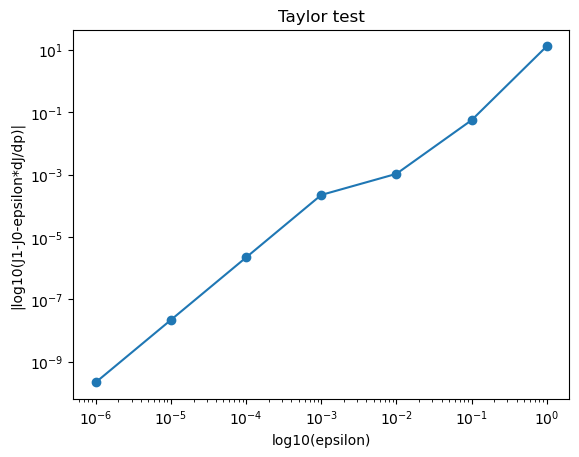

In [86]:
# OBJECTIVE SQUARED L2 OF RESERVOIR STATES
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = len(U_grad)
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
dJ_dp = np.zeros(my_ESN.N_param_dim)
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    q_prev = q   
    dJ_dp += np.dot(2*X_pred_grad[i,:],q)
dJ_dp = (1/N)*dJ_dp

# calculate gradient for a timeseries, adjoint method
# time averaged objective
v_prev = (1/N)*2*X_pred_grad[N-1,:]
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i,:]).toarray().T,v_prev)
    v = np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray().T,v_prev)+ (1/N)*2*X_pred_grad[i-1,:].T
    v_prev = v

# calculate gradient for a timeseries, numerical method
# time averaged objective 
h = 1e-5
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_grad.copy()
    P_left[:,i] -= h
    P_right = P_grad.copy()
    P_right[:,i] += h
    X_left, _ = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
    X_right, _ =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
    J_left = np.mean(np.sum(X_left**2, axis = 1))
    J_right = np.mean(np.sum(X_right**2, axis = 1))
    dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
print(dJ_dp)
print(dJ_dp_adj)
print(dJ_dp_num)

# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
J_0 = np.mean(np.sum(X_pred_grad[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_grad.copy()
        P_right[:,i] += epsilon
        X_right, _ =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_1 = np.mean(np.sum(X_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dp_adj[i]
        print("J_1-J_0:", J_1-J_0, "J_1-J_0/epsilon",(J_1-J_0)/epsilon)

plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

[5.62494064]
[5.62494064]
[5.62494064]
J_1-J_0: 1.8850197737114627 J_1-J_0/epsilon 1.8850197737114627
J_1-J_0: 0.48855019433754165 J_1-J_0/epsilon 4.8855019433754165
J_1-J_0: 0.055458248804884036 J_1-J_0/epsilon 5.545824880488404
J_1-J_0: 0.005616814575555296 J_1-J_0/epsilon 5.616814575555296
J_1-J_0: 0.0005624128030827791 J_1-J_0/epsilon 5.624128030827791
J_1-J_0: 5.624859374542268e-05 J_1-J_0/epsilon 5.624859374542267
J_1-J_0: 5.624932510883696e-06 J_1-J_0/epsilon 5.624932510883696
J_1-J_0: 5.62493982059209e-07 J_1-J_0/epsilon 5.62493982059209


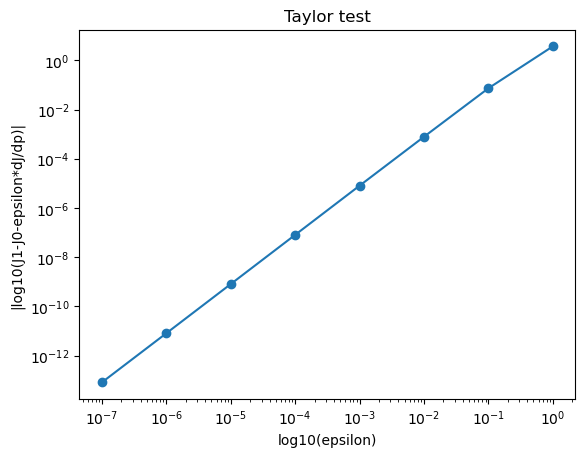

In [170]:
# OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
# calculate gradient for a timeseries, direct method
# time averaged objective
#N = X_pred_train.shape[0]
N = len(U_grad)
q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
dJ_dp = np.zeros(my_ESN.N_param_dim)
for i in np.arange(1,N):
    q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    q_prev = q 
    X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    dJ_dp += np.dot(dJ_dr,q)

# calculate gradient for a timeseries, adjoint method
# time averaged objective
X_pred_aug = np.hstack((X_pred_grad[N-1,:], my_ESN.b_out))
v_prev = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
for i in np.arange(N-1,0,-1):
    dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i,:]).toarray().T,v_prev)
    X_pred_aug = np.hstack((X_pred_grad[i-1,:], my_ESN.b_out))
    dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T).T
    v = np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray().T,v_prev)+dJ_dr 
    v_prev = v

# calculate gradient for a timeseries, numerical method
# time averaged objective 
h = 1e-5
dJ_dp_num = np.zeros((my_ESN.N_param_dim))
for i in range(my_ESN.N_param_dim):
    P_left = P_grad.copy()
    P_left[:,i] -= h
    P_right = P_grad.copy()
    P_right[:,i] += h
    X_left, Y_left = my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_left)
    X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
    J_left = 1/4*np.mean(np.sum(Y_left**2, axis = 1))
    J_right = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
    dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
print(dJ_dp)
print(dJ_dp_adj)
print(dJ_dp_num)

# Taylor test
epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
J_0 = 1/4*np.mean(np.sum(Y_pred_grad_[:N,:]**2, axis = 1))
taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
for epsilon_idx, epsilon in enumerate(epsilon_list):
    for i in range(my_ESN.N_param_dim):
        P_right = P_grad.copy()
        P_right[:,i] += epsilon
        X_right, Y_right =  my_ESN.closed_loop(X_pred_grad[0,:], N-1, P_right)
        J_1 = 1/4*np.mean(np.sum(Y_right**2, axis = 1))
        taylor[epsilon_idx, i] = J_1-J_0-epsilon*dJ_dp_adj[i]
        print("J_1-J_0:", J_1-J_0, "J_1-J_0/epsilon",(J_1-J_0)/epsilon)

plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
plt.xlabel("log10(epsilon)")
plt.ylabel("|log10(J1-J0-epsilon*dJ/dp)|")
plt.xscale("log")
plt.yscale("log")
plt.title("Taylor test")
plt.show()

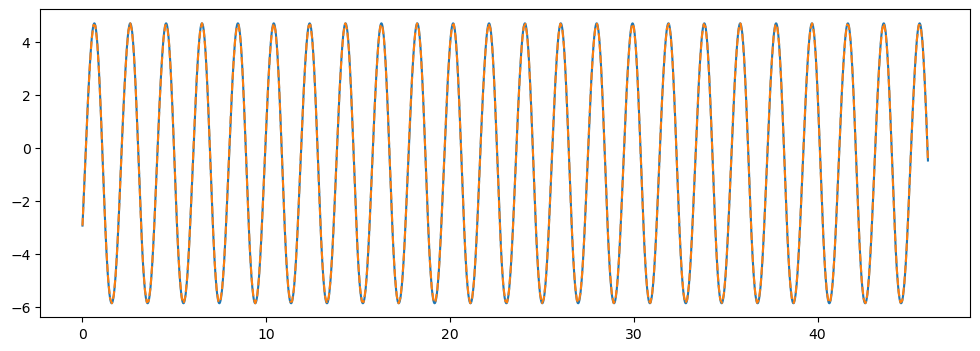

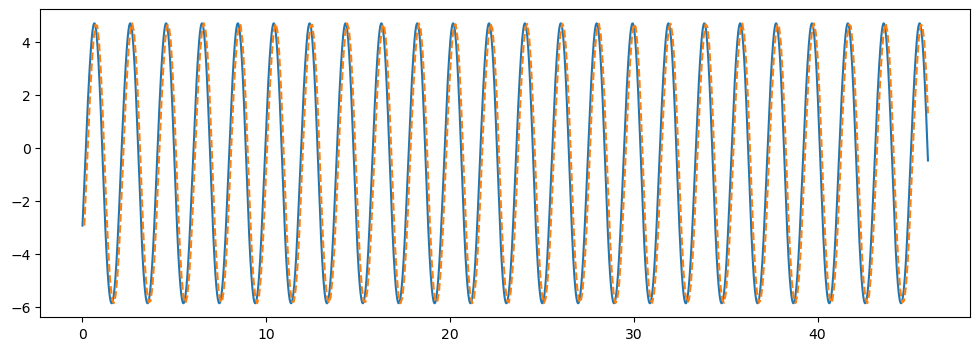

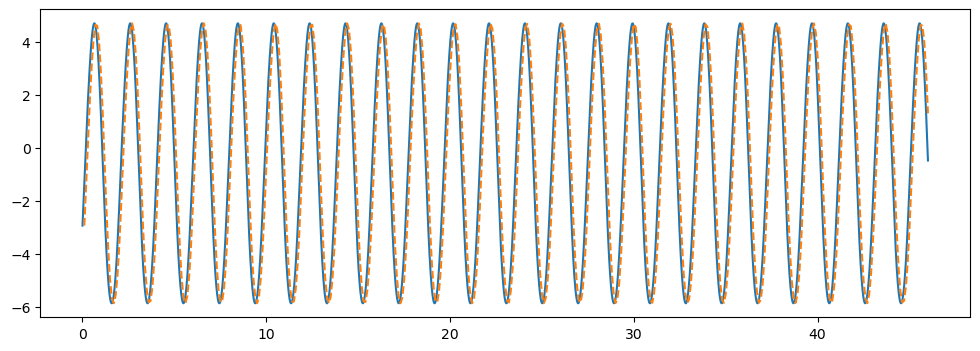

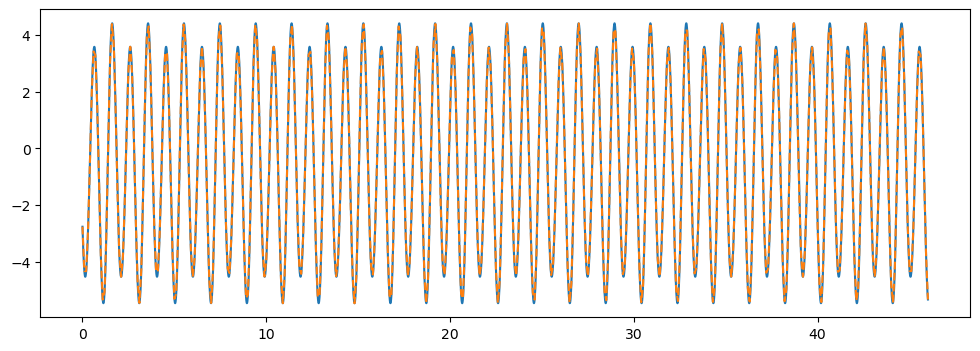

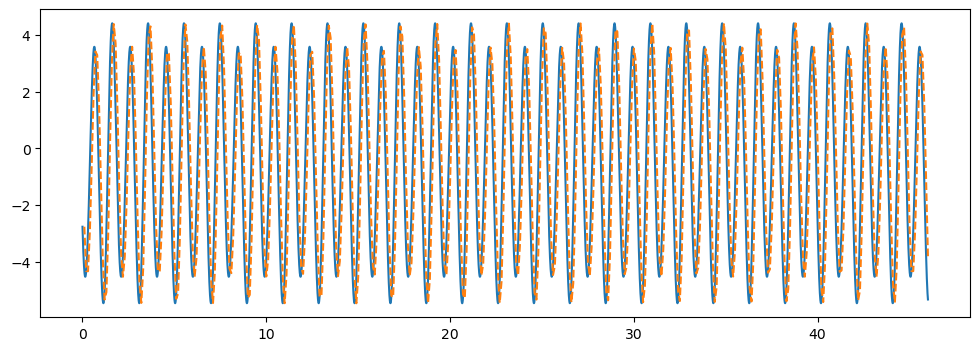

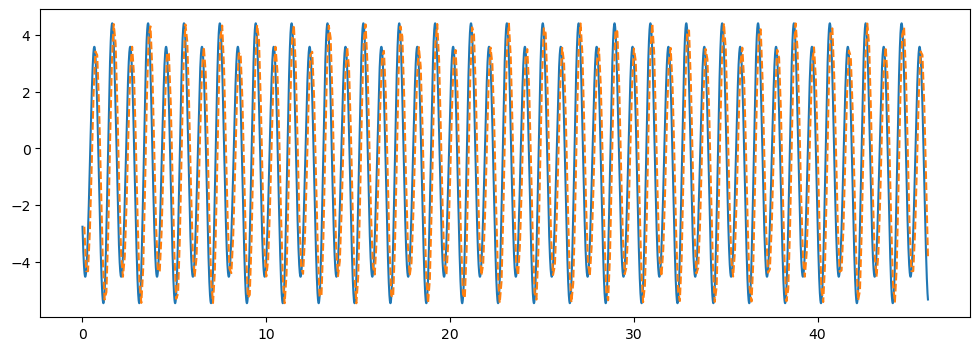

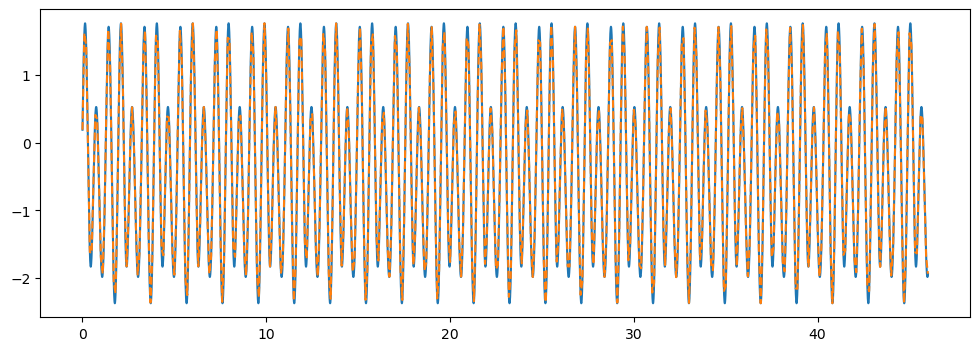

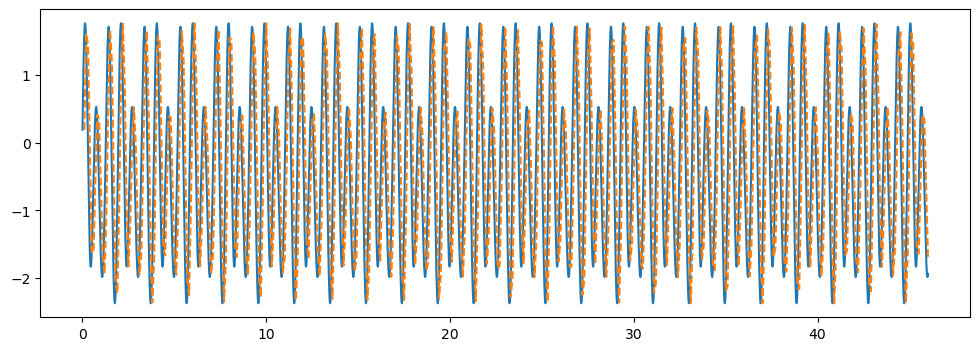

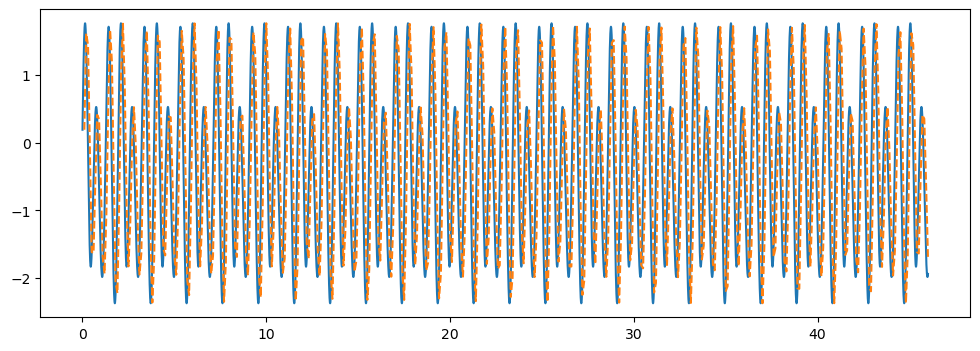

In [99]:
for j in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(t_bar,y_bar[:,j])
    plt.plot(t_grad,Y_pred_grad_[:,j],'--')

    plt.figure(figsize=(12,4))
    plt.plot(t_bar,y_bar_beta_left[:,j])
    plt.plot(t_grad[1:],Y_left[:,j],'--')

    plt.figure(figsize=(12,4))
    plt.plot(t_bar,y_bar_beta_right[:,j])
    plt.plot(t_grad[1:],Y_right[:,j],'--')

In [129]:
true_grad = np.array([3.831,4.380,4.673,4.90,5.134])
esn_grad = np.array([3.257,4.877,6.288,5.85,5.567])
true_grad-esn_grad

array([ 0.574, -0.497, -1.615, -0.95 , -0.433])